In [1]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2023-06-16 00:26:18--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2023-06-16 00:26:18--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2023-06-16 00:26:19--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [3]:
import numpy as np
fruits = np.load("fruits_300.npy")
fruits_2d = fruits.reshape(-1, 100 * 100)

In [7]:
# PCA: Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components = 50)      # 50 components -> (reduce the dimentionality to) 50
pca.fit(fruits_2d)

PCA(n_components=50)

In [8]:
# Find the principal component(s) that PCA found
print(pca.components_.shape)

(50, 10000)


In [11]:
# A simple utility function that which cluster means which image
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio = 1):
  n = len(arr)                  # sample count
  rows = int(np.ceil(n / 10))   # 10 images per line
  cols = n if rows < 2 else 10
  fig, axs = plt.subplots(rows, cols, figsize = (cols * ratio, rows * ratio), squeeze = False)

  for i in range(rows):
    for j in range(cols):
      if i * 10 + j < n:
        axs[i, j].imshow(arr[i * 10 + j], cmap = "gray_r")
      axs[i, j].axis("off")

  plt.show()

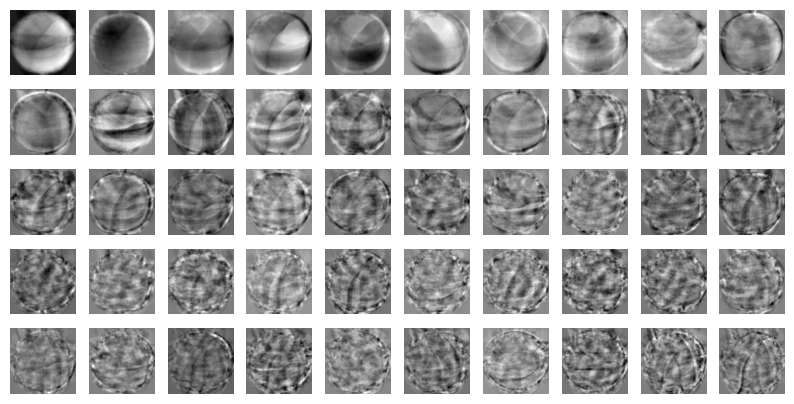

In [12]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [13]:
print(fruits_2d.shape)

(300, 10000)


In [14]:
# Reduce the dimensionality of the original data to 50
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


In [16]:
# From transformed(reduced) data, inverse the procedure
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)         # 100 * 100 = 10,000 features has been recovered (as original)

(300, 10000)


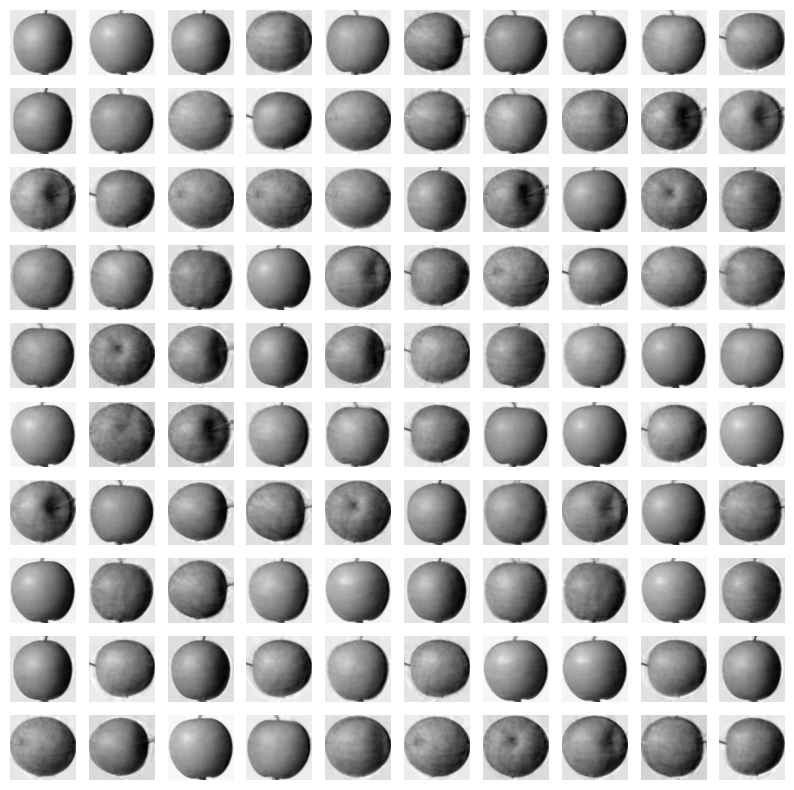

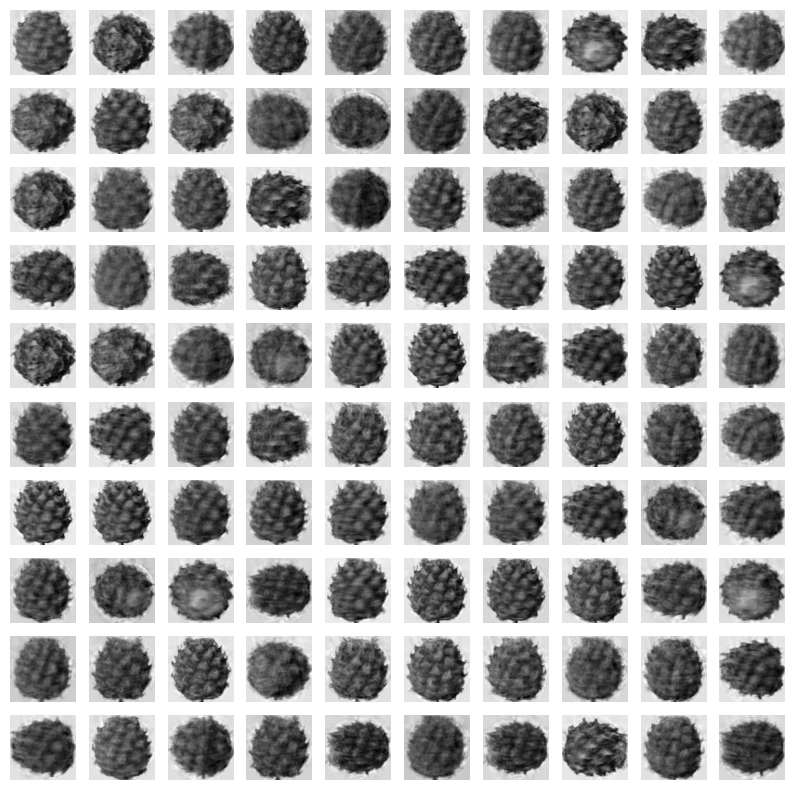

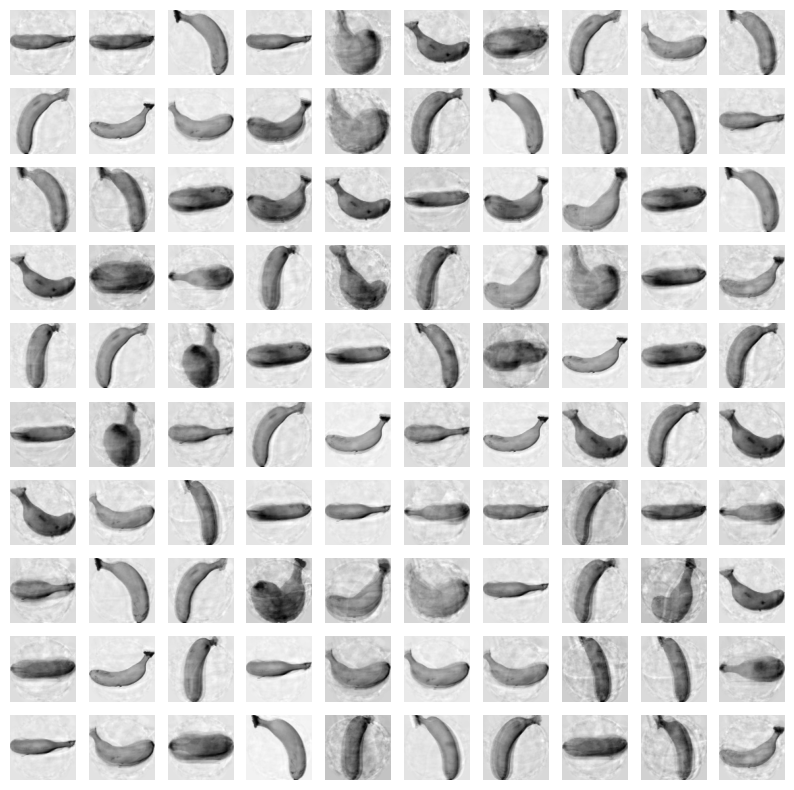

In [18]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

for start in [0, 100, 200]:
  draw_fruits(fruits_reconstruct[start : start + 100])
  print("\n")

In [23]:
# How well does the principal components represent the original data's variance?

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))  # sum up 50 principal components

[0.42357017 0.09941755 0.06577863 0.04031172 0.03416875 0.03281329
 0.02573267 0.02054963 0.01372276 0.01342773 0.01152146 0.00944596
 0.00878232 0.00846697 0.00693049 0.00645188 0.00578895 0.00511202
 0.00486382 0.00480347 0.00447833 0.00437317 0.00408041 0.00389473
 0.00372429 0.00359287 0.00331429 0.00317838 0.00304288 0.00303684
 0.00288889 0.00275837 0.00264972 0.00255846 0.00252186 0.00246996
 0.00239438 0.00230965 0.00221906 0.00216738 0.00213606 0.00196429
 0.0019261  0.00190755 0.001848   0.001828   0.00173915 0.00168512
 0.00162515 0.00155122]
0.9215248064558873


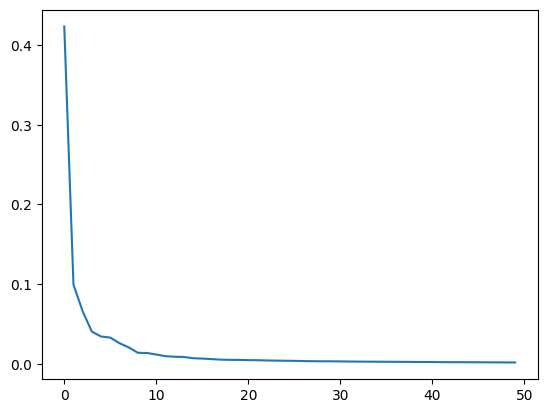

In [25]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

# We can see that the top 10 principal components participate in most of the variances.

### PCA vs other algorithm

In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [27]:
# Because LR is a supervised model, so we need a target
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [31]:
from sklearn.model_selection import cross_validate

# Original data
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores["test_score"]))              # How accurate the model is
print(np.mean(scores["fit_time"]))                # How long did it take to fit

# PCA-processed data
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores["test_score"]))
print(np.mean(scores["fit_time"]))

0.9966666666666667
3.333551120758057
1.0
0.08186368942260742


In [32]:
pca = PCA(n_components = 0.5)     # Target explained variance (the model will iteratively run until this target)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [34]:
print(pca.n_components_)

# It means only just 2 components are required to represent 50% of original data's variance!

2


In [35]:
# Let's use this data(n_components_ = 2) to learning
fruitss_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


In [38]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores["test_score"]))
print(np.mean(scores["fit_time"]))

# Even though there are only 2 principal components,
# the model still shows excellent performance

1.0
0.029580020904541017


In [39]:
# With dimensionality-reduced data, find the clusters with K-average algorithm
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 3, random_state = 42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts = True))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2], dtype=int32), array([111,  98,  91]))


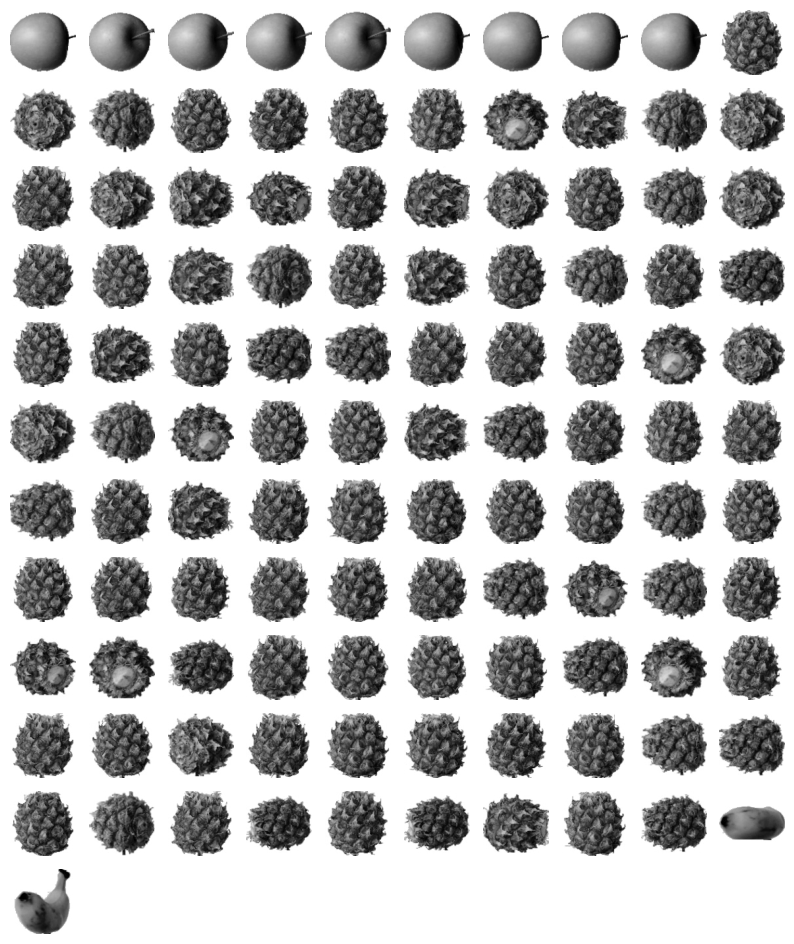

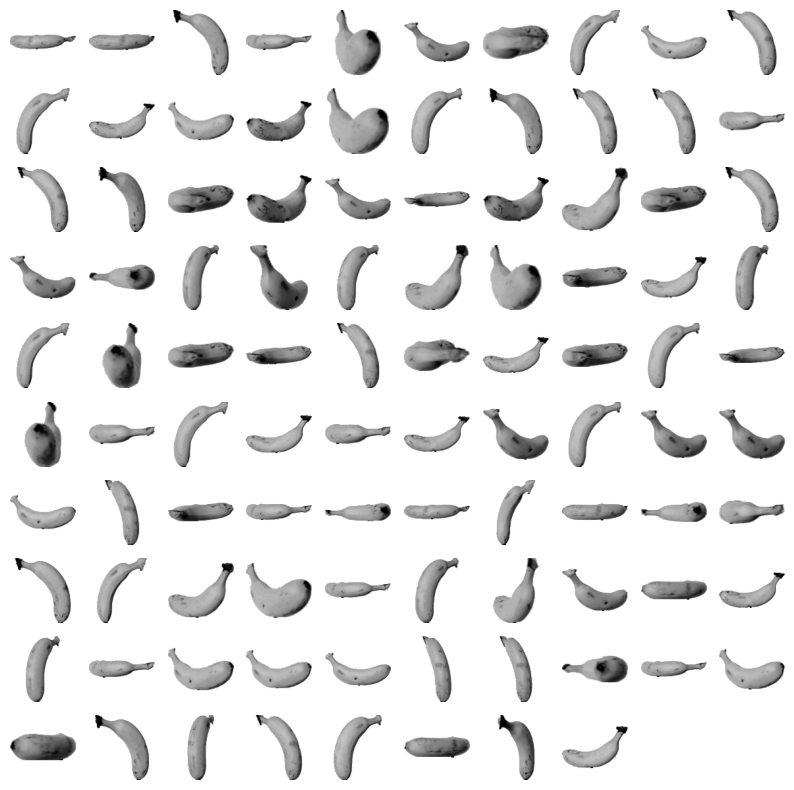

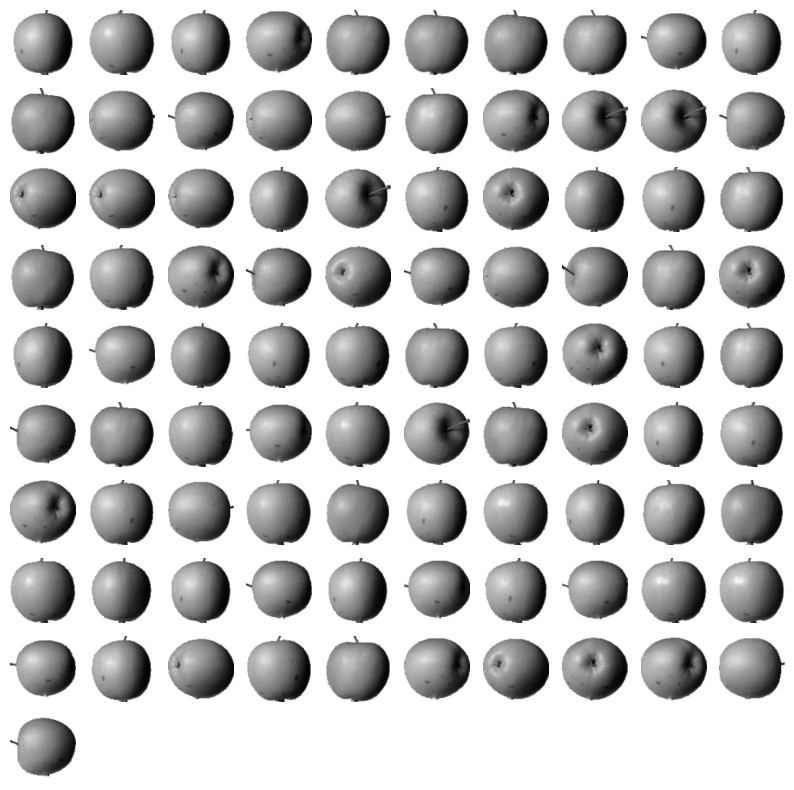

In [40]:
for label in range(0, 3):
  draw_fruits(fruits[km.labels_ == label])
  print("\n")

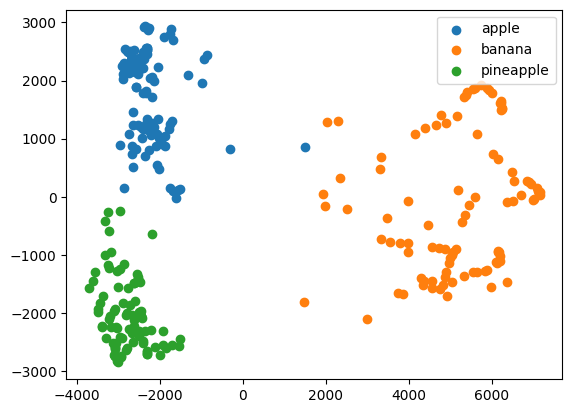

In [41]:
# It is very easy to visualize the result on the screen if we successfully reduce the dimensionality below 3.

for label in range(0, 3):
  data = fruits_pca[km.labels_ == label]
  plt.scatter(data[:,0], data[:,1])

plt.legend(["apple", "banana", "pineapple"])
plt.show()